# Semi-Supervised Learning (SSL)

**Student: Lucas Versini**

SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = None
params['c_u'] = None

In [3]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = params["num_classes"] if "num_classes" in params else len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    l_idx = np.where(Y > 0)[0]
    u_idx = np.where(Y == 0)[0]
    y = np.zeros((num_samples, num_classes))
    y[l_idx, Y[l_idx].astype(int) - 1] = 1
    
    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx, :]

        L_uu = L[u_idx, :][:, u_idx] # L_TT
        L_ul = L[u_idx, :][:, l_idx] # L_TS
        f_u = np.linalg.solve(L_uu, -L_ul @ f_l)

        f = np.zeros((num_samples, num_classes))
        f[l_idx, :] = f_l
        f[u_idx, :] = f_u

    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        c_l = params['c_l']
        c_u = params['c_u']

        C = np.zeros((num_samples, num_samples))
        C[l_idx, l_idx] = c_l
        C[u_idx, u_idx] = c_u

        f = np.linalg.pinv(C) @ L
        f = np.linalg.solve(f + np.eye(num_samples), y)

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis = 1) + 1

    return labels, f

In [4]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', per_class = False, plot=True, verbose = True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l, per_class)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    L = build_laplacian_regularized(X,
                                    laplacian_regularization = params['laplacian_regularization'],
                                    var = params['var'],
                                    eps = params['eps'],
                                    k = params['k'],
                                    laplacian_normalization = params['laplacian_normalization'])

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))

    if verbose:
        print(f"Soft={soft}, Accuracy={accuracy}")
        
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

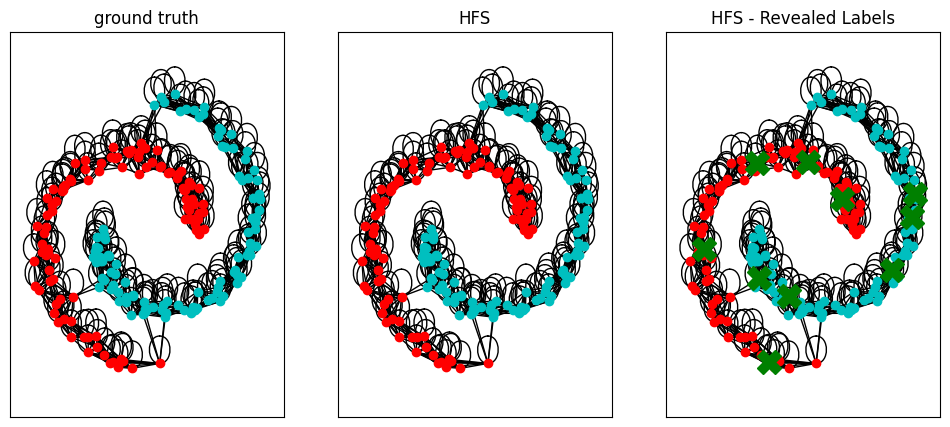

Soft=False, Accuracy=1.0


In [5]:
seed = 42

params['laplacian_normalization'] = 'unn'
params['k'] = 11

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l = 10, l_noisy = 0, soft = False,
                                                 dataset = 'data_2moons_hfs.mat', plot = True, seed = seed,
                                                 **params)

**Answer**:

Using a knn-graph, an unnormalized Laplacian matrix, and $k = 11$, we achieve an accuracy of $100 \%$.

However, it is quite obvious that using a low value of $k$ leads to a high accuracy.

Using the *random walk* normalization and $k = 20$ yields an accuracy of $94.5 \%$, which is still quite good.

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [6]:
np.random.seed(42)

params["k"] = 30 # Larger k so the problem is not trivial
params["laplacian_normalization"] = "rw"

for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l = 4, l_noisy = 0, soft = False, 
                                                     dataset = 'data_2moons_hfs_large.mat',
                                                     per_class = True, # to avoid issues
                                                     plot = False, seed = None, **params)
    
# mask_labels?  # check parameters

Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


**Answer:**

When using `l = 4`, there is only a small number of labels. As a consequence, it is possible (and likely) to get points which all belong to the same class (because we only sample 4 points...). Then, an error is raised thanks to `assert len(np.unique(Y_masked)) > 2, "only one class in training data!"`. In the code above, using a seed of 3 does not raise any error, but using a seed of 42 does.

Of course, if $l$ is larger, then is it less likely to get such an error.

Another way of fixing this error is, in `two_moons_hfs`, to use `per_class = True` when using `mask_labels`. That way, we are guaranteed to have some points for each label (and thus not only one label). We changed the function `two_moons_hfs` to take `per_class` as an argument.

If we use `per_class = True`, we get an accuracy of $100\%$ on this large dataset, which proves that the model is indeed good.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

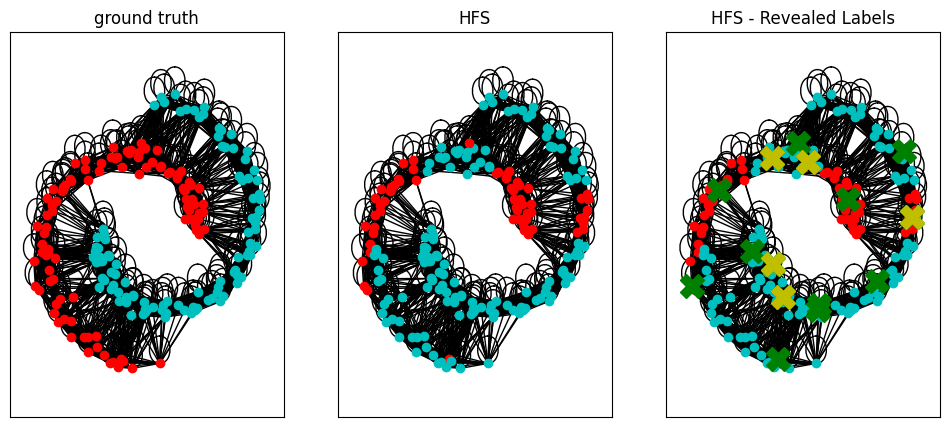

Soft=False, Accuracy=0.72


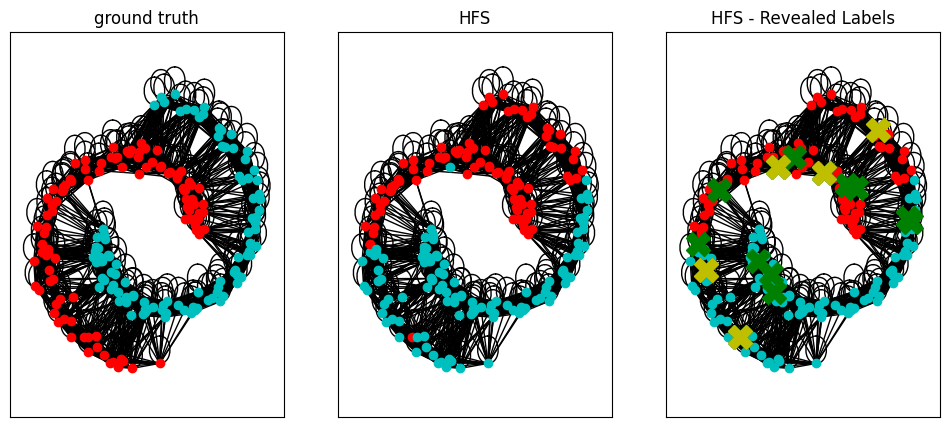

Soft=True, Accuracy=0.725

Hard: 0.685 +- 0.088
Soft: 0.717 +- 0.084


In [7]:
# Comparing
seed = None  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

params['k'] = 25
params['laplacian_normalization'] = 'rw'

params['c_l'] = 0.95
params['c_u'] = 0.05

accu_hard = []
accu_soft = []

# Run HFS 20 times and store the accuracies
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot = (ii == 0), seed=seed, verbose = (ii == 0), **params)
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                     plot = (ii == 0), seed=seed, verbose = (ii == 0), **params)
    accu_hard.append(hard_accuracy)
    accu_soft.append(soft_accuracy)

# Print results
print()
print(f"Hard: {np.mean(accu_hard):.3f} +- {np.std(accu_hard):.3f}")
print(f"Soft: {np.mean(accu_soft):.3f} +- {np.std(accu_soft):.3f}")

**Answer**:

We observe (using a rather large value of `k` to avoid making the task too easy) that soft HFS performs better than hard HFS : the accuracy is higher on average, and its standard deviation is lower (so the algorithm is more stable).

A way to understand this is that hard HFS does not change the given labels, whereas soft HFS can do it; since these labels are noisy, and thus not necessarily accurate, not changing them can yield errors which can propagate.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

**Answer:**

First of all, I one-hot encoded the labels : a label $l \in [\![ 1, \dots, C ]\!]$ is turned into a vector $\ell \in \mathbb{R}^C$, with $\ell_l = 1$ and $\ell_i = 0$ for $i \neq l$.

An unlabeled sample is assigned the null vector $(0, \dots, 0)$.

Then, the harmonic function is $f \in \mathbb{R}^{N \times C}$ instead of $f \in \mathbb{R}^N$.

Finally, the prediction is obtained by taking the argmax of the label vector (and adding 1 because our indices start at 0).

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

**Answer:**

The parameters that were used can be found below.

I modified the `preprocess_image` function, using Contrast Limited Adaptive Histogram.

The best accuracy I obtained for the small dataset is 87 %.

The best accuracy I obtained for the augmented dataset is  72.6%.


### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

**Answer:**

When using the augmented dataset, the accuracy decreases by 14.4 %.

A first explanation is the fact that in the augmented dataset, 92% of the labels are masked (4 labels per class), compared to 60% (still 4 labels per class) in the small dataset. Therefore the ratio of missing labels is higher for the augmented dataset, making the task harder. This difference of ratio may not be a problem on easier datasets (like two moons), but with the face dataset, it probably is.

This shows that adding data does not always increase the performance. However, this depends on the additional data: in our case, some of the additional images are clearly harder (some people being side viewed); as seen in one of the next cells in the confusion matrix, some of the people are hard to distinguish from some other people. And of course, if the additional data had more labels, it would make things easier (and the accuracy would probably be higher).

In [8]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [9]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.05
params_face_rec['var'] = 100.0
params_face_rec['eps'] = None
params_face_rec['k'] = 10
params_face_rec['laplacian_normalization'] = 'rw'
params_face_rec['c_l'] = 0.9
params_face_rec['c_u'] = 0.1

In [10]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
        
    """
    output_frame_size = 96   # do not change the output frame size!
    
    image = cv2.bilateralFilter(image, 3, 75,75)
    image = cv2.createCLAHE(tileGridSize = (12, 12)).apply(image) # Contrast Limited Adaptive Histogram Equalization
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(float)
    im -= im.mean()
    im /= im.max()
    image = im
    
    return image

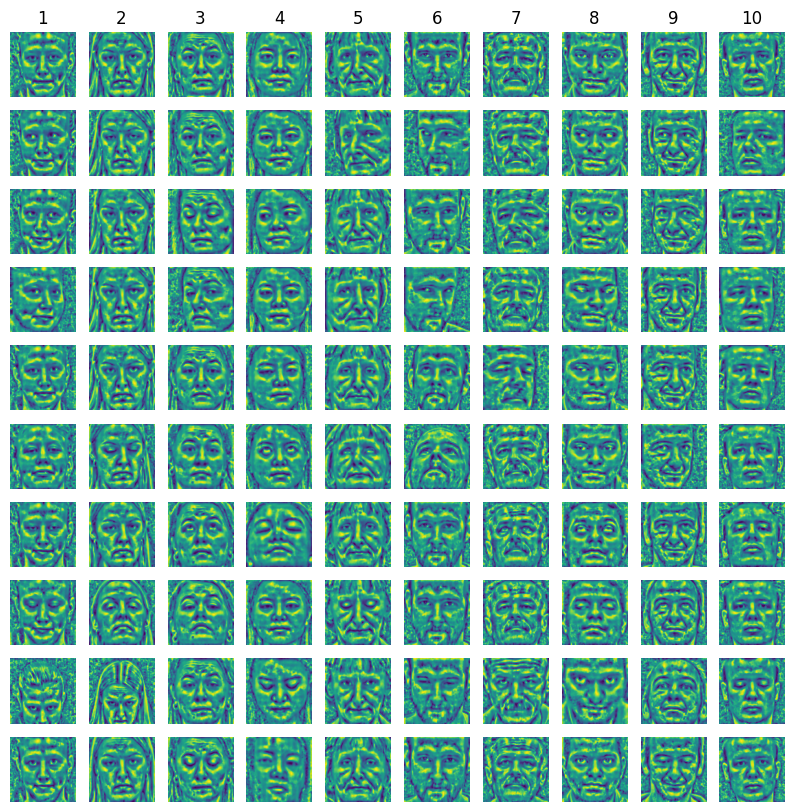

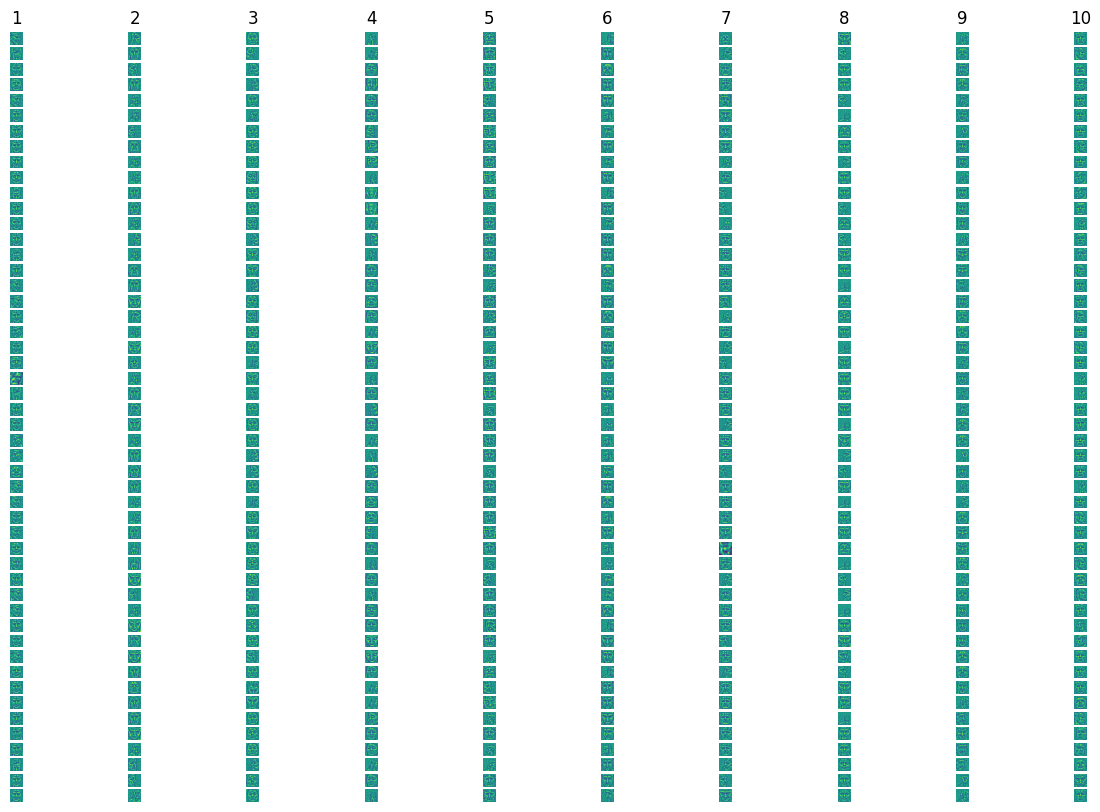

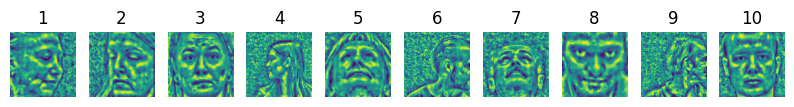

In [11]:
np.random.seed(456)   # set seed, since labels are masked randomly

# 10 images per person
images, labels, masked_labels = load_image_data(preprocess_image)
plot_image_data(images)

# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

# Some samples of the augmented dataset
plot_image_data(images_a[:10])

In [12]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

L_a = build_laplacian_regularized(images_a,
                                    params_face_rec['laplacian_regularization'], 
                                    params_face_rec['var'], 
                                    params_face_rec['eps'], 
                                    params_face_rec['k'], 
                                    params_face_rec['laplacian_normalization'])

Accuracy (small dataset) =  0.87


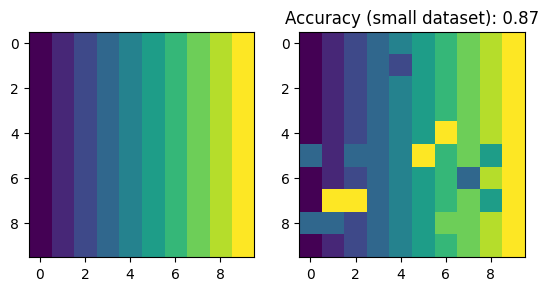

Accuracy (augmented dataset) =  0.726


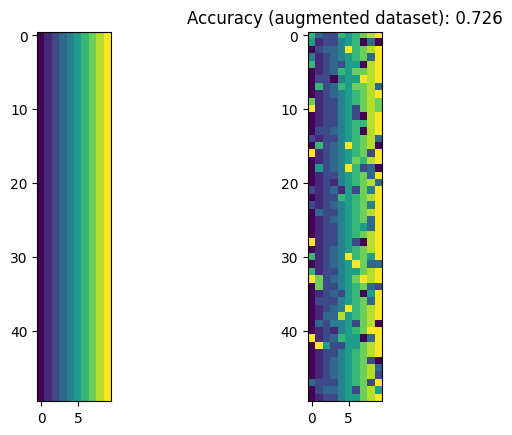

In [13]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy (small dataset) = ", accuracy)

# print(masked_labels)
# print(predicted_labels)
# print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy (small dataset): {}".format(accuracy))
plt.show()

# Run HFS on augmented data
predicted_labels_a, f_a = compute_hfs(L_a, masked_labels_a, soft=True, **params_face_rec)
accuracy_a = np.equal(predicted_labels_a, labels_a).mean()
print("Accuracy (augmented dataset) = ", accuracy_a)

# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy (augmented dataset): {}".format(accuracy_a))
plt.show()

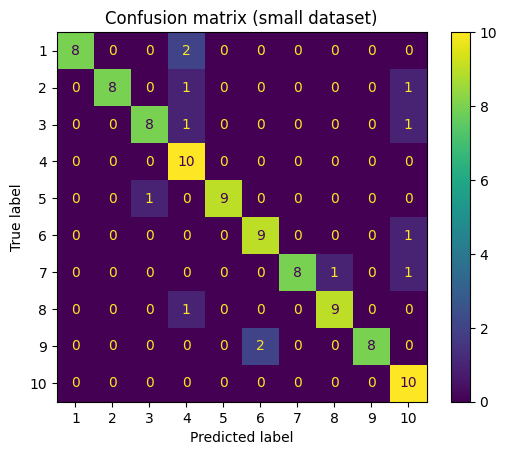

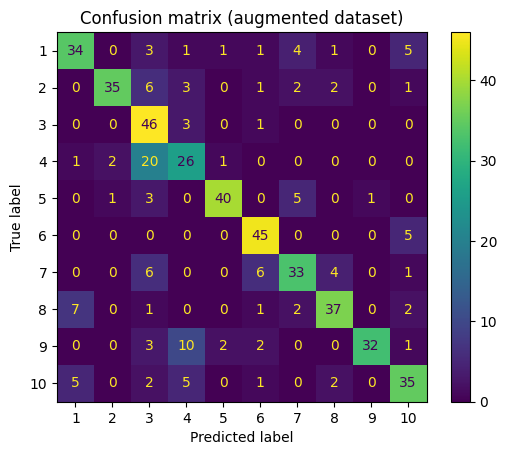

In [14]:
# confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# small dataset
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))
disp.plot()
plt.title("Confusion matrix (small dataset)")
plt.show()

# augmented dataset
cm_a = confusion_matrix(labels_a, predicted_labels_a)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.unique(labels_a))
disp.plot()
plt.title("Confusion matrix (augmented dataset)")
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

**Answer**: Having no webcam, I used online videos: [this one](https://pixabay.com/videos/thinking-think-idea-man-person-82130/) and [this one](https://pixabay.com/videos/man-surprise-thinking-idea-122389/).

Below are some results which we will comment:

<table>
    <tr>
        <td><img src="results/frame_0.png" width="500"></td>
        <td><img src="results/frame_1.png" width="500"></td>
    </tr>
</table>

<table>
    <tr>
        <td><img src="results/frame_6.png" width="500"></td>
        <td><img src="results/frame_7.png" width="500"></td>
    </tr>
</table>

Globally the implemented method works, each Bob is well recognized.

However for Bob 1, we see that the score drops a lot when he puts his hand in front of his face. This is because we did not put any such image in the labeled dataset. If we put a threshold not too low, then this face is labeled as unknown.

For Bob 2, we see (second row, first column) that the face is correctly classified (with a high score) even when looking to the left of the image, whereas no such image was used in the labeled dataset. However, we also see (second row, second column) that there can be misclassifications with a high score.

   
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


**Answer**:

With the previous algorithm, an unknown face can be classified as a label, even though the score is low. What can therefore be done is to assign any face with a low score to the "unknown" label. In `online_ssl_compute_solution`, we change the label to "unknown" when the score is below a chosen threshold.

In the above images, when the score was low (for example between 0.4 and 0.5), with a high enough threshold (say 0.5), the image would have been misclassified as "unknown".

Below, we show an image of [someone](https://pixabay.com/videos/man-coffee-pause-relaxation-216598/) who is not Bob 1 nor Bob 2, and who is indeed classified as "unknown" (with a score of about 0.10).

<td><img src="results/frame_8.png" width="500"></td>

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [16]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = 0.
params_online_ssl['k'] = 12
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 0.9
params_online_ssl['c_u'] = 0.1

In [17]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50, new_person = False):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
        
        self.new_person = new_person # whether to add new labels
        print(self.new_person)
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """
        assert (self.image_dimension == len(face)), "new image not of good size"
        
        print(self.centroids.shape[0], self.max_num_centroids + 1)

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            dist = self.centroids_distances.copy()
            dist[self.taboo, :] = np.inf
            dist[:, self.taboo] = np.inf
            c1, c2 = np.unravel_index(np.argmin(dist), dist.shape)
            assert not (self.taboo[c1] and self.taboo[c2]), "Two taboo centroids are closest"

            if self.taboo[c1]:
                c_rep, c_add = c1, c2
            elif self.taboo[c2]:
                c_rep, c_add = c2, c1
            elif self.V[c2] <= self.V[c1]:
                c_rep, c_add = c1, c2
            else:
                c_rep, c_add = c2, c1

            """
            Update data structures: self.centroids and self.V
            """
            if not self.new_person:
                print("Minus one")
                # We do not add new labels
                self.V[c_rep] += self.V[c_add]
                self.centroids[c_add, :] = face
                self.V[c_add] = 1
            else:
                print("Zero")
                if not self.taboo[c_rep] and self.V[c_rep] >= 10:
                    print("One")
                    # Unlabeled face seen enough times : label it
                    self.taboo[c_rep] = self.taboo[c_add] = True
                    new_label = np.max(self.Y) + 1
                    self.Y[c_rep] = self.Y[c_add] = new_label
                    self.label_names += [f"Person {new_label}"]
                    self.n_labeled_faces += 1
                    self.n_labels += 1
                if self.taboo[c_rep] and (self.Y == self.Y[c_rep]).sum() < 5:
                    print("Two")
                    # Face labeled, but rarely seen : add c_add to the dataset
                    self.Y = np.append(self.Y, self.Y[c_rep])
                    self.taboo = np.append(self.taboo, True)
                    self.centroids = np.concatenate([self.centroids, np.array([self.centroids[c_add]])], axis = 0)
                    self.V = np.append(self.V, self.V[c_add])

                    dist_new = distance.cdist(np.array([self.centroids[-1]]), self.centroids)[0]
                    self.centroids_distances = np.concatenate([self.centroids_distances, np.array([dist_new[:-1]]),], axis = 0)
                    self.centroids_distances = np.concatenate([self.centroids_distances, np.array([dist_new]).T], axis = 1)
                    
                    self.n_labeled_faces += 1
                    self.max_num_centroids += 1
                else:
                    print("Three")
                    self.V[c_rep] += self.V[c_add]

                self.centroids[c_add, :] = face
                self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        W = build_similarity_graph(self.centroids,
                                   var = params_online_ssl['var'],
                                   eps = params_online_ssl['eps'],
                                   k = params_online_ssl['k'])
        L = build_laplacian(V @ W @ V, laplacian_normalization = params_online_ssl['laplacian_normalization'])
        Q = L + params_online_ssl['laplacian_regularization'] * np.eye(L.shape[0]) # regularized Laplacian

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))
        
        # handle unknown faces
        label_scores = [x for x in label_scores if x[1] > 0.7]
        if len(label_scores) == 0:
            label_scores = [('Unknown', score)]

        return label_scores    


In [18]:
# create_user_profile('bob1', video_filename = "bob1.mp4")         # choose your names here :)
# create_user_profile('bob2', video_filename = "bob2.mp4")
# online_face_recognition(['bob1', 'bob2'], IncrementalKCenters, n_pictures=10, video_filename = "charlie_man.mp4")

### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

**Answer**:

In the case of unsupervised classification, an abnormal eigenvalue (i.e., too large compared to the others) means we deal with another cluster. In incremental clustering, a high multiplicity on a given centroid may mean we deal with a new face.

Therefore:

- If there is a face that has no label, but often appears, we label it (with a new label).
- If there is a face that has a label, but raraly appears, we add $c_{\text{rep}}$ to the dataset.
- Otherwise, we do as before.

To do this, we modify the `__init__` function of `IncrementalKCenters`, to add a parameter `new_person`.

Below are two pictures from the same video; at first the [woman](https://pixabay.com/videos/girl-woman-female-model-human-48255/) is "unknown", and then she is recognized.

<table>
    <tr>
        <td><img src="results/frame_9.png" width="500"></td>
        <td><img src="results/frame_10.png" width="500"></td>
    </tr>
</table>

In [19]:
# from functools import partial

# online_face_recognition(['bob1', 'bob2'], partial(IncrementalKCenters, new_person = True),
#                         n_pictures = 10, video_filename = "charlie_woman.mp4")

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

**Answer**:

We focus on the first two (Supervised vs Semi-Supervised and Inductive vs Transductive).

**Supervised vs Semi-supervised**:

For the semi-supervised classifier, we use soft HFS, and for the supervised classifier, a SVC.

To enable the SVC to handle the data, we use a PCA, with 20 components, for both models.


We choose $u$ missing data. The supervised model is trained on $l$ data, the semi-supervised model on $l + u$ data. Both models are then evaluated on the whole dataset, of size $N$.

Then, we plot the accuracy (on the $N$ data) against the ratio of missing data $u$.

We observe that the semi-supervised learning performs better, no matter the ratio of missing data.

As expected, the accuracy of both model decreases when the ratio of missing data increases. However, for a high ratio, the difference between supervised learning and semi-supervised learning is much clearer, which is expected: not many images are labeled, so supervised learning struggles, whereas semi-supervised learning manages to leverage the non-labeled data.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:10<00:00,  1.01s/it]


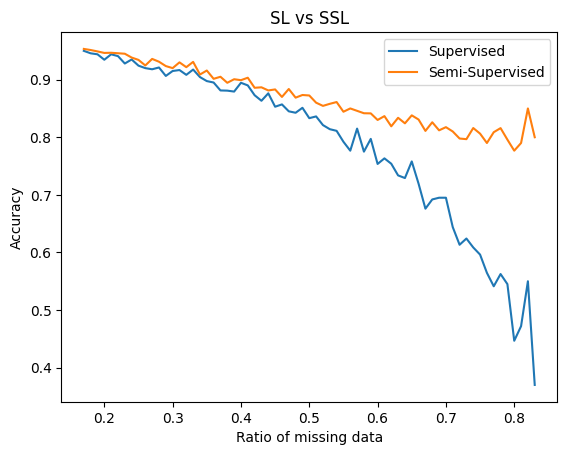

In [20]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tqdm import tqdm
import pandas as pd

# Load images
images, labels, _ = load_image_data(preprocess_image)

# Parameters
params_face_rec = {}
params_face_rec["laplacian_regularization"] = 1.0
params_face_rec["var"] = 10.0
params_face_rec["eps"] = None
params_face_rec["k"] = 20
params_face_rec["laplacian_normalization"] = "rw"
params_face_rec["c_l"] = 0.8
params_face_rec["c_u"] = 0.1

# Run experiments

accuracy = []
for l in tqdm(np.arange(80, 10, -1)):
    for i in range(10):
        masked_labels = mask_labels(labels, l, per_class = False)
        masked_labels[:10] = np.arange(1, 11)

        labeled_imgs = images[masked_labels != 0]

        # Semi Supervised Learning
        pca = PCA(n_components = min(20, len(labeled_imgs))).fit(images)
        images_pca = pca.transform(images)
        L = build_laplacian_regularized(images_pca,
                                        params_face_rec["laplacian_regularization"],
                                        params_face_rec["var"],
                                        params_face_rec["eps"],
                                        params_face_rec["k"],
                                        params_face_rec["laplacian_normalization"])

        predicted_labels_ssl, f = compute_hfs(L, masked_labels, num_classes = 10, soft = True, **params_face_rec)
        accuracy_ssl = np.equal(predicted_labels_ssl, labels).mean()

        # Supervised Learning
        pca = PCA(n_components = min(20, len(labeled_imgs))).fit(labeled_imgs)
        labeled_images_pca = pca.transform(labeled_imgs)
        clf = SVC()
        clf.fit(labeled_images_pca, labels[masked_labels != 0])

        images_pca = pca.transform(images)
        predicted_labels_sl = clf.predict(images_pca)
        accuracy_sl = np.equal(predicted_labels_sl, labels).mean()

        # Store results
        accuracy.append({"missing": np.mean(masked_labels == 0),
                         "accuracy (SL)": accuracy_sl,
                         "accuracy (SSL)": accuracy_ssl})

accuracy = pd.DataFrame.from_records(accuracy)

# Plot
avg_accuracy = accuracy.groupby(["missing"]).mean()

plt.figure()

plt.plot(avg_accuracy.index, avg_accuracy["accuracy (SL)"], label = "Supervised")
plt.plot(avg_accuracy.index, avg_accuracy["accuracy (SSL)"], label = "Semi-Supervised")

plt.title("SL vs SSL")
plt.xlabel("Ratio of missing data")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

**Answer**:

**Inductive vs Transductive**:

Now, we keep a proportion $m = 0.3$ of the data to create a test set.

The supervised learning model is trained on $l$ samples, then evaluated on the $m$ samples.

The semi-supervised learning model is trained on $l + u$ samples, then its predictions for the $u$ non-labeled samples are used to create pseudo-labels. A SSL model is then trained on the true labels as well as the pseudo-labels, and then evaluated on the $m$ samples.

We observe below that the two models perform more or less as well when there is not much unlabeled samples (transductive).

When the ratio of missing data becomes large, the semi-supervised model performs much better, because it is trained on more labels (though some of them are pseudo labels).

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:58<00:00,  1.03it/s]


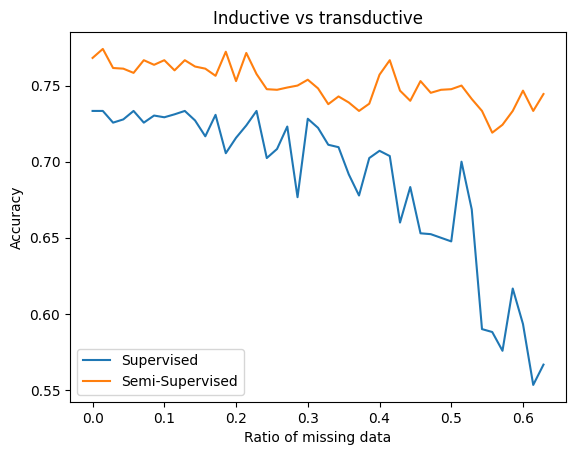

In [21]:
# Split data
idx_train, idx_test = np.arange(70), np.arange(70, 100)
images_train, labels_train = images[idx_train], labels[idx_train]
images_test, labels_test = images[idx_test], labels[idx_test]

# Run experiments

accuracy = []
for l in tqdm(np.arange(80, 20, -1)):
    for i in range(10):
        masked_labels = mask_labels(labels_train, l, per_class = False)
        masked_labels[:10] = np.arange(1, 11)

        labeled_imgs_train = images_train[masked_labels != 0]

        # Semi Supervised Learning
        pca = PCA(n_components = min(20, len(labeled_imgs_train))).fit(images_train)
        images_pca = pca.transform(images_train)
        L = build_laplacian_regularized(images_pca,
                                        params_face_rec["laplacian_regularization"],
                                        params_face_rec["var"],
                                        params_face_rec["eps"],
                                        params_face_rec["k"],
                                        params_face_rec["laplacian_normalization"])

        pseudo_labels, f = compute_hfs(L, masked_labels, num_classes = 10, soft = True, **params_face_rec)
        pseudo_labels = np.append(pseudo_labels, np.zeros(30))
        
        images_pca = pca.transform(images)
        L = build_laplacian_regularized(images_pca,
                                        params_face_rec["laplacian_regularization"],
                                        params_face_rec["var"],
                                        params_face_rec["eps"],
                                        params_face_rec["k"],
                                        params_face_rec["laplacian_normalization"])
        predicted_labels_ssl, f = compute_hfs(L, pseudo_labels, num_classes = 10, soft = True, **params_face_rec)
        accuracy_ssl = np.equal(predicted_labels_ssl[idx_test], labels_test).mean()

        # Supervised Learning
        pca = PCA(n_components = min(20, len(labeled_imgs_train))).fit(labeled_imgs_train)
        labeled_images_pca = pca.transform(labeled_imgs_train)
        clf = SVC()
        clf.fit(labeled_images_pca, labels_train[masked_labels != 0])

        images_pca_test = pca.transform(images_test)
        predicted_labels_sl = clf.predict(images_pca_test)
        accuracy_sl = np.equal(predicted_labels_sl, labels_test).mean()

        # Store results
        accuracy.append({"missing": np.mean(masked_labels == 0),
                         "accuracy (SL)": accuracy_sl,
                         "accuracy (SSL)": accuracy_ssl})

accuracy = pd.DataFrame.from_records(accuracy)

# Plot
avg_accuracy = accuracy.groupby(["missing"]).mean()

plt.figure()

plt.plot(avg_accuracy.index, avg_accuracy["accuracy (SL)"], label = "Supervised")
plt.plot(avg_accuracy.index, avg_accuracy["accuracy (SSL)"], label = "Semi-Supervised")

plt.title("Inductive vs transductive")
plt.xlabel("Ratio of missing data")
plt.ylabel("Accuracy")

plt.legend()
plt.show()